In [3]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
import kaggle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
path = '/kaggle/input/nlp-getting-started/'
files = os.listdir(path)
files

['sample_submission.csv', 'train.csv', 'test.csv']

## Exploratory data analysis

In [4]:
train_df = pd.read_csv(path + 'train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_df = pd.read_csv(path + 'test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<p style="font-size: 16px; color: blue;">
In this project, we will use RNNs to classify tweets as disasters or not, as keeping with the content of this weeks coursework. <br>
The dataset includes multiple columns, which may be pertinent to us in the classification process. For example, the keyword column could be a useful predictor or even the location if we could somehow categorize the highly susceptible locations for various disaster types. However, to demonstrate the application of RNNs, I will only consider the tweet column as the predictor and convert that to a useful format for data analysis later in the project. <br>

<p style="font-size: 16px; color: blue;">
Checking the number of 1s and 0s, i.e., disaster vs non-disaster tweets

<Axes: >

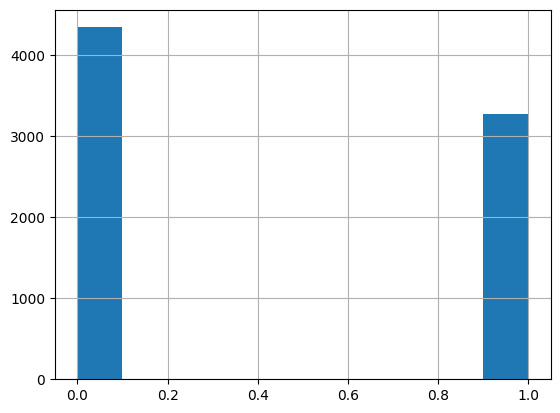

In [8]:
train_df['target'].hist()

In [9]:
train_df.groupby('target').count()['text']/len(train_df)

target
0    0.57034
1    0.42966
Name: text, dtype: float64

<p style="font-size: 16px; color: blue;">
Since the dataset is skewed with more tweets being non-disaster and identifying the distaster tweets is critical, it would be optimal to have a model with high recall. Recall tells us the ratio of correctly classified disasters to the total number of actual distaster tweets.<br>
In this project, in keeping with the requirments of the Kaggle competition, we will use F1-score as our metric for the analysis, which captures both precision and recall and is a good proxy for recall. 

## Data pre-processing

<p style="font-size: 16px; color: blue;">
Next, we will clean the tweets and make them appropriate for data analysis. <br>
First, we will convert all the tweets to lowercase, as the case of the letters should be immaterial to the content. Next, remove any urls from the tweets, assuming that they may not by themselves convey much information. Lastly, we will remove any special characters from the tweets.<br>
Morever, we can see from the information on the tweet column in training dataframe above that some of the tweets are null. We may consider removing them; however, keeping them should not affect the analysis, as the data pre-processing (cleaning, lemmatization, and tokenization) below will convert them to the right format and will avoid any spurious behavior during the model training. However, we may question if this would affect the perfromance of the model. Since we are not concerned with making super-efficeint models in this project and also null tweets are low in number, I will leave them for now. 

In [10]:
# cleaning the text

def cleanText(text):
    # lower-casing the text
    text = text.lower()
    # clean for any url
    text = re.sub('https:\S+|http:\S+|www.\S+', '',text)
    # clean for any special characters
    text = re.sub('[^a-zA-z\s]','', text)
    return text

<p style="font-size: 16px; color: blue;">
Next, we will remove any stopwords from the tweets, i.e., common use words like personal pronous(I, we, us, etc.) and supportive verbs (is, am, would, etc.). We will also lemmatize the tweets, meaning we will reduce different forms of a word to the root word. For example, we will eliminate the singulars and plurals with the singular form.<br>
The process of removing the stopwords and lemmatization reduces the size of the tweets by removing words which likely do not help with classification.

In [1]:
# importing, downloading, and unzipping the requisite packages
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# need to unzip the wordnet manually after this
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/

<p style="font-size: 16px; color: blue;">
Helper function to lemmatize and remove the stopwords.

In [8]:
stpwrds = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def lemmatizeText(text):
    words = text.split()
    words = [lemmatizer.lemmatize(x) for x in words if x not in stpwrds]
    return ' '.join(words)

<p style="font-size: 16px; color: blue;">
Cleaning and lemmatizing the training and test tweets

In [14]:
X = train_df['text']
X = list(map(lambda x: cleanText(x), X))
X = list(map(lambda x: lemmatizeText(x), X))

In [15]:
X_test = test_df['text']
X_test = list(map(lambda x: cleanText(x), X_test))
X_test = list(map(lambda x: lemmatizeText(x), X_test))

<p style="font-size: 16px; color: blue;">
Checing the distribution of lenght of the tweets after cleaning and lemmatization.

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23]


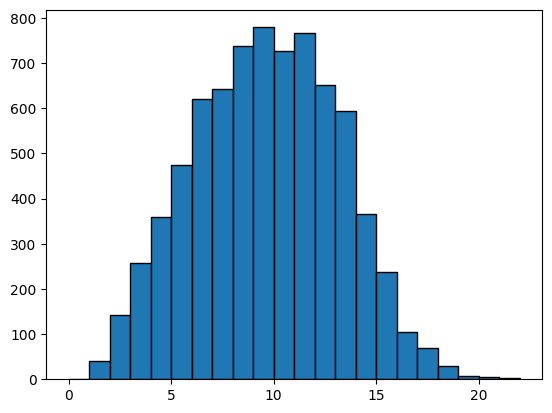

In [16]:
X_lens = list(map(lambda x: len(x.split()), X))
print(np.unique(X_lens))
plt.hist(X_lens, edgecolor = 'black', bins = list(range(23)))
plt.show()

<p style="font-size: 16px; color: blue;">
We will next tokenize the tweets to make it suitable for analsysi through RNN architectures.
I will also reduce the size of each tweet to 20, as, in the above histogram plot, we can see that most of the tweets have size 20 or less. We may play around with this number to check if it affects performance of the model. However, to avoid inundating most tweets with unrecognized words 

In [18]:
# initializing a tokenizer with the unknown word to be considered as OOV.
tokenizer = Tokenizer(oov_token = 'OOV')

# fiting the tokenizer on both the training and the test dataset, as incorporating words from
# the test set only increases the vocabulary of the tokenizer, not doing anything spurious.
tokenizer.fit_on_texts(X + X_test)

# Tokening the train data
train_data = tokenizer.texts_to_sequences(X)
max_length = 20

# padding the tokenized train data to make all the tweets of the same length
train_data = pad_sequences(train_data, maxlen = max_length, padding = 'post')

# tokening and padding the test data
test_data = tokenizer.texts_to_sequences(X_test)
test_data = pad_sequences(test_data, maxlen = max_length, padding = 'post')
# X_train

In [19]:
# vocabulary size of the tokenizer
len(tokenizer.word_index)

19516

In [20]:
# shape of the training data after tokenization and padding
train_data.shape

(7613, 20)

In [21]:
# Converting the labels for the training data to the appropriate shape for further analysis.
y = np.array(train_df['target'])
y = y.reshape((len(y), 1))

In [23]:
# Renaming the variables appropriately
X_train = train_data
y_train = y
X_test = test_data

In [24]:
y_train

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

## Model creation

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, GRU
from tensorflow.keras.metrics import F1Score

## Simple RNN followed by dense layers

In [67]:
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128),
    SimpleRNN(units=128),
    Dense(units=128, activation='relu'),
    Dense(units=1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', metrics = [F1Score(threshold = 0.5)])
model.optimizer = Adam(learning_rate= 0.0001)
model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 20, 128)             │       2,498,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,547,713 (9.72 MB)

 Trainable params: 2,547,713 (9.72 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[es])

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - f1_score: 0.2456 - loss: 0.6690 - val_f1_score: 0.5958 - val_loss: 0.5982
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - f1_score: 0.7641 - loss: 0.4263 - val_f1_score: 0.7035 - val_loss: 0.5268
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - f1_score: 0.8782 - loss: 0.2662 - val_f1_score: 0.6890 - val_loss: 0.6020
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - f1_score: 0.9423 - loss: 0.1516 - val_f1_score: 0.6377 - val_loss: 0.7277
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - f1_score: 0.9551 - loss: 0.1173 - val_f1_score: 0.6676 - val_loss: 0.8032
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - f1_score: 0.9667 - loss: 0.0869 - val_f1_score: 0.6422 - val_loss: 0.8270
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - f1_score: 0.9645 - loss: 0.0806 - val_f1_score: 0.6519 - val_loss: 0.9977
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - f1_score: 0.9786 - loss: 0.0530 - val_f1_score: 0

<font color = 'blue'>
<font size = 3>
A helper function to plot the history scores of the model.

In [31]:
def plot_history(hist):
  fig, ax = plt.subplots(1, 2, figsize=(12, 4))
  ax[0].plot(hist.epoch, hist.history['loss'], label='Training Loss')
  ax[0].plot(hist.epoch, hist.history['val_loss'], label='Validation Loss')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epochs')
  ax[1].plot(hist.epoch, hist.history['f1_score'], label='Training F1 score')
  ax[1].plot(hist.epoch, hist.history['val_f1_score'], label='Validation F1 score')
  ax[1].set_ylabel('F1 score')
  ax[1].set_xlabel('Epochs')
  ax[0].legend()
  ax[1].legend()
  plt.show()
  return

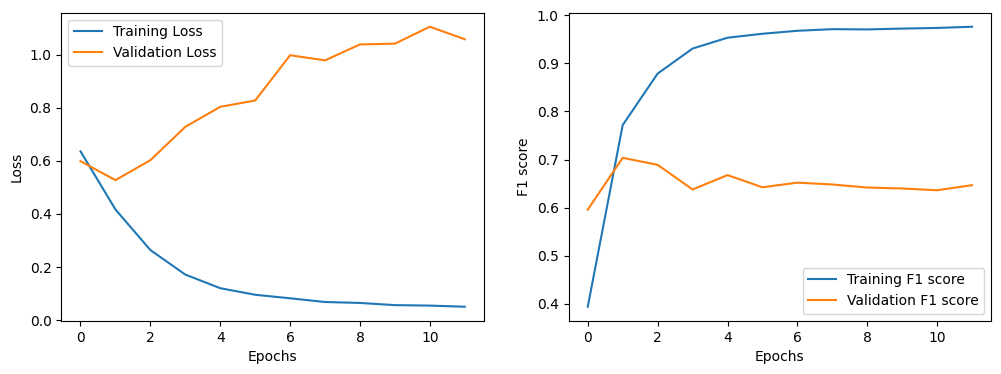

In [70]:
plot_history(hist)

<font color = 'blue'>
<font size = 3>
Helper functions to do predictions on the test set and upload that to Kaggle and get scores on it.

In [32]:
# predicting on the test dataset
def predictOnTeset(model):
    res = (model.predict(X_test) > 0.5).astype(int)
    return res.flatten()

# Creating and uploading a test result csv file to Kaggle
def createFileAndUploadToKaggle(filename, predictions):
    path = '/kaggle/working/'
    pd.DataFrame({'id': test_df['id'], 'target':predictions}).to_csv(path + filename, index= False)
    kaggle.api.authenticate()
    subms = kaggle.api.competition_submit(path + filename,'ghhb','nlp-getting-started')
    return subms

# Obtaining score on the test dataset from Kaggle
def getKaggleScore(subms):
    kaggle.api.authenticate()
    sublist = kaggle.api.competitions_submissions_list('nlp-getting-started')
    # print(subms.ref)
    for sub in sublist:
        if(sub['ref'] == subms.ref): 
            print('The accuracy score is', sub['publicScore'])
            return sub['publicScore']

In [84]:
res = predictOnTeset(model)
subms = createFileAndUploadToKaggle('ModelRNN.csv', res)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


100%|██████████| 22.2k/22.2k [00:00<00:00, 116kB/s]


In [85]:
score = getKaggleScore(subms)

The accuracy score is 0.76126


<font color = 'blue'>
<font size = 3>
Model 1 is the simpletest RNN architecure followed by dense networks to squeeze out the final data. We can see that the validation loss quickly starts to rise after a few epochs, while the F1 score settles down, thus indicating that subsequent epochs are just overfitting.<br>
As for the test set F1 score, it is about 0.76.

### Model 2 (LSTM followed by dense layers)

<font color = 'blue'>
<font size = 3>
Below, I will create an LSTM model followed by dense layers. Since in the previous model, the validation loss quickly went high at low epoch numbers, I will use a lower learning rate in the next model.

In [38]:
model_lstm = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


model_lstm.compile(loss='binary_crossentropy', metrics = [F1Score(threshold = 0.5)])
model_lstm.optimizer = Adam(learning_rate= 0.000025)
model_lstm.build(input_shape=(None, max_length))
model_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 20, 64)              │       1,249,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,284,225 (4.90 MB)

 Trainable params: 1,284,225 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
es = EarlyStopping(monitor='val_f1_score', patience=10, restore_best_weights=True)
hist_lstm = model_lstm.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[es])

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - f1_score: 0.4162 - loss: 0.6927 - val_f1_score: 0.0000e+00 - val_loss: 0.6913
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_score: 0.0000e+00 - loss: 0.6879 - val_f1_score: 0.0000e+00 - val_loss: 0.6891
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_score: 0.0000e+00 - loss: 0.6784 - val_f1_score: 0.0000e+00 - val_loss: 0.6886
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_score: 0.0000e+00 - loss: 0.6738 - val_f1_score: 0.0000e+00 - val_loss: 0.6838
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_score: 0.0185 - loss: 0.6472 - val_f1_score: 0.3442 - val_loss: 0.6191
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_score: 0.6299 - loss: 0.5091 - val_f1_score: 0.7151 - val_loss: 0.5351
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_score: 0.8233 - loss: 0.3699 - val_f1_score: 0.7387 - val_loss: 0.5220
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_score: 0.8588 - los

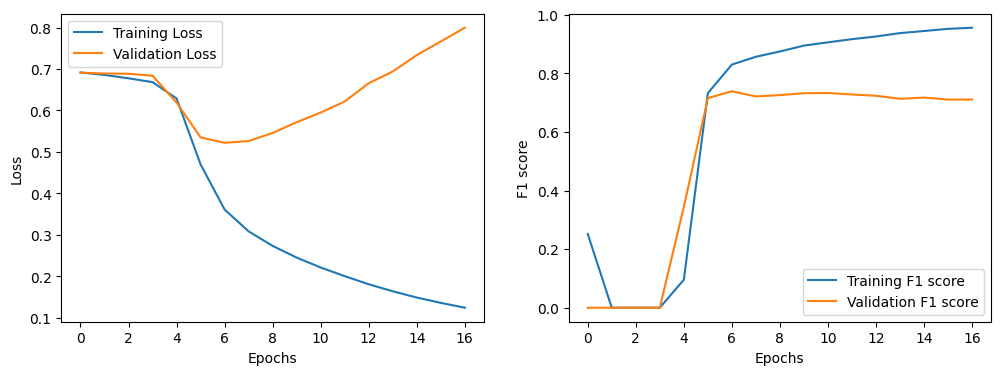

In [40]:
plot_history(hist_lstm)

In [41]:
res = predictOnTeset(model_lstm)
subms = createFileAndUploadToKaggle('ModelLSTM.csv', res)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


100%|██████████| 22.2k/22.2k [00:00<00:00, 51.7kB/s]


In [42]:
score = getKaggleScore(subms)

The accuracy score is 0.76402


<font color = 'blue'>
<font size = 3>
Above, we created an LSTM model followed by dense layers, and it achieved a similar performance to that of the simple RNN model on the test.

### LSTM model with drop out layers for regularization

In [95]:
model_lstm_WithDropout = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=256),
    LSTM(256, return_sequences=False),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model_lstm_WithDropout.compile(optimizer='adam', loss='binary_crossentropy', metrics = [F1Score(threshold = 0.5)])
model_lstm_WithDropout.build(input_shape=(None, max_length))
model_lstm_WithDropout.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 20, 256)             │       4,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,595,713 (21.35 MB)

 Trainable params: 5,595,713 (21.35 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist_lstm_WithDropout = model_lstm_WithDropout.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[es])

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - f1_score: 0.2855 - loss: 0.6484 - val_f1_score: 0.7588 - val_loss: 0.4699
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.8486 - loss: 0.3339 - val_f1_score: 0.7494 - val_loss: 0.5391
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.9237 - loss: 0.1891 - val_f1_score: 0.7273 - val_loss: 0.5790
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.9475 - loss: 0.1345 - val_f1_score: 0.7118 - val_loss: 1.2371
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.9605 - loss: 0.0947 - val_f1_score: 0.7228 - val_loss: 1.0308
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.9595 - loss: 0.0810 - val_f1_score: 0.7184 - val_loss: 0.9900
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.9631 - loss: 0.0659 - val_f1_score: 0.7234 - val_loss: 1.6472
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.9663 - loss: 0.0655 - val_f1_score: 0

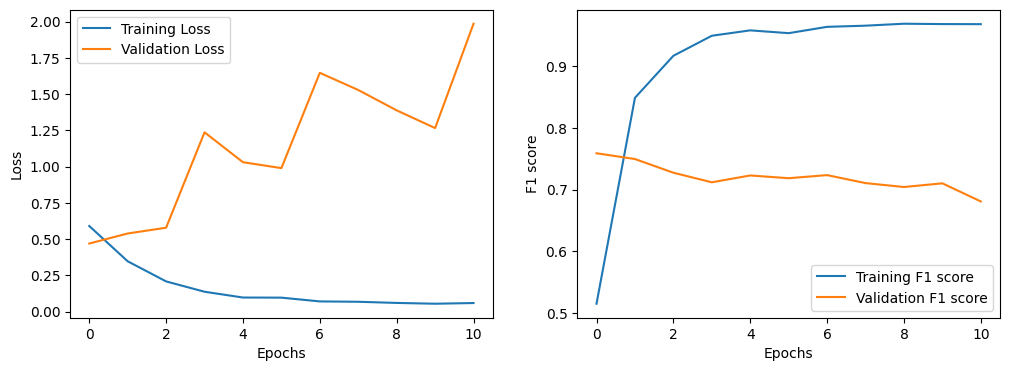

In [97]:
plot_history(hist_lstm_WithDropout)

In [98]:
res = predictOnTeset(model_lstm_WithDropout)
subms = createFileAndUploadToKaggle('Model_lstm_WithDropout.csv', res)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


100%|██████████| 22.2k/22.2k [00:00<00:00, 121kB/s]


In [99]:
score = getKaggleScore(subms)

The accuracy score is 0.79252


<font color = 'blue'>
<font size = 3>
There might be a possibility that the drop out layers for regularization may have helped with the F1 score on the test set, increasing it to 0.79. However, we also cannot preclude that it could be due to the variation of the model training, coming from a random split between training and the validation data during the fitting process.

### GRU model followed by Dense layers

<Font color = 'blue'>
<Font size = 3>
Below, we create a GRU model. Ideally, it should be similar to the LSTM model; nevertheless, we will check its performance.

In [27]:
modelGRU = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=256),
    GRU(256),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
modelGRU.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics = [F1Score(threshold = 0.5)])

# Print model summary
modelGRU.build(input_shape=(None, max_length))
modelGRU.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 256)             │       4,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 256)                 │         394,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,465,153 (20.85 MB)

 Trainable params: 5,465,153 (20.85 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist_GRU = modelGRU.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[es])

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - f1_score: 0.1728 - loss: 0.6906 - val_f1_score: 0.0000e+00 - val_loss: 0.7111
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - f1_score: 0.3394 - loss: 0.6245 - val_f1_score: 0.7650 - val_loss: 0.4548
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - f1_score: 0.8486 - loss: 0.3116 - val_f1_score: 0.7527 - val_loss: 0.5021
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - f1_score: 0.9351 - loss: 0.1627 - val_f1_score: 0.7441 - val_loss: 0.6117
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - f1_score: 0.9600 - loss: 0.0938 - val_f1_score: 0.7256 - val_loss: 0.9395
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - f1_score: 0.9716 - loss: 0.0718 - val_f1_score: 0.7321 - val_loss: 1.3982
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - f1_score: 0.9735 - loss: 0.0539 - val_f1_score: 0.7224 - val_loss: 1.0853
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.9785 - loss: 0.0506 - val_f1_scor

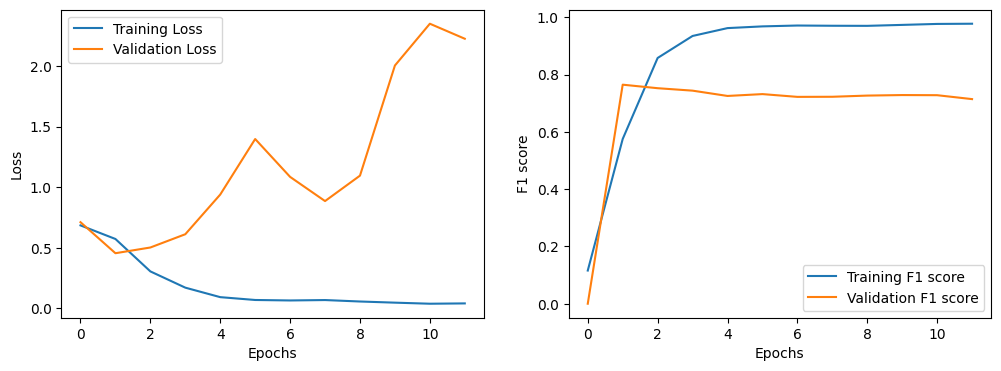

In [33]:
plot_history(hist_GRU)

In [34]:
res = predictOnTeset(modelGRU)
subms = createFileAndUploadToKaggle('ModelGRU.csv', res)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


100%|██████████| 22.2k/22.2k [00:00<00:00, 57.9kB/s]


In [36]:
score = getKaggleScore(subms)

The accuracy score is 0.79558


<Font color = 'blue'>
<Font size = 3>
The accuracy with GRU is quite similar the LSTU model. Moreover, the history plots including loss and F1 scores for the GRU model and the LSTM model are also quite alike.


## Conclusion

<p style="font-size: 16px; color: blue;">
We created the following models and their results on the test dataset are as follows:<br></p>

<table>
  <table style="font-size: 16px">

  <tr>
    <th>Model type</th>
    <th>F1 score</th>
  </tr>
  <tr>
    <td>Simple RNN model followed by dense layers</td>
    <td>0.7613</td>
  </tr>
  <tr>
    <td>LSTM model followed by dense layers</td>
    <td>0.7640</td>
  </tr>
  <tr>
    <td>LSTM model with drop out layers for regularization</td>
    <td>0.7925</td>
  </tr>
  <tr>
    <td>GRU model with drop out layers for regularization</td>
    <td>0.7956</td>
  </tr>
  </p>
</table>
</table>

<p style="font-size: 16px; color: blue;">
It seems like we can make the following conclusions:<br>
<ul>
    <li> <p style="font-size: 16px; color: blue;"> The simple RNN model gives a descent 0.76 F1 score on the test set. However, there is potenstial to imporove this further by tweaking hyperparameters like number of dense layers, type optimizers, learning rates, etc.</li>
    <li> <p style="font-size: 16px; color: blue;"> The LSTM model without any regularization didn't perform much different from the simple RNN model; however, we can still tweak hyper-parameters like those mentioned above and check for further scores</li>
    <li> <p style="font-size: 16px; color: blue;"> The LSTM models and GRU models with dropout layers for regularization performed somewhat better than the previous ones.</li>
    <li> <p style="font-size: 16px; color: blue;"> I also observed that the lemmatizer we used above in the notebook wasn't the best. It didn't take into account many verb forms that could have had the same roots, so a better lemmetizing the text could be helpful with the analysis.</li>
</ul>
    

<Font color = 'blue'>
<Font size = 3>
